In [127]:
import pandas as pd
import torch
import textwrap

from itertools import islice
from torch.utils.data import IterableDataset, Dataset, DataLoader, random_split
from torch import nn
from torchtext.data.functional import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt

# Familiarize with the data.

In [128]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("=== Dataset Overview ===")
print(f"Shape (rows, cols): {train_df.shape}\n")

print("=== Columns and Data Types ===")
print(train_df.dtypes.to_string(), "\n")

print("=== First 5 Examples ===")
display(train_df.head())   # in Jupyter/Colab, gives a nice table view

print("\n=== Target Distribution (label balance) ===")
print(train_df['target'].value_counts().to_string(), "\n")

print("=== Missing Values per Column ===")
print(train_df.isna().sum().to_string(), "\n")

print("=== Example Tweet (target=1, disaster) ===")
print(train_df[train_df['target']==1]['text'].iloc[0], "\n")

print("=== Example Tweet (target=0, not disaster) ===")
print(train_df[train_df['target']==0]['text'].iloc[0])

=== Dataset Overview ===
Shape (rows, cols): (7613, 5)

=== Columns and Data Types ===
id           int64
keyword     object
location    object
text        object
target       int64 

=== First 5 Examples ===


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1



=== Target Distribution (label balance) ===
target
0    4342
1    3271 

=== Missing Values per Column ===
id             0
keyword       61
location    2533
text           0
target         0 

=== Example Tweet (target=1, disaster) ===
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 

=== Example Tweet (target=0, not disaster) ===
What's up man?


# Preprocessing the data.

First we split the data into: 
1. Training Data
2. Validation Data
3. Test Data

In [129]:
# Handle missing values
train_df["keyword"] = train_df["keyword"].fillna("<unk>") 
test_df["keyword"] = test_df["keyword"].fillna("<unk>")

class TweetsIterable(IterableDataset):
    """
    Yields (label:int, text:str), just like AG_NEWS.
    """
    def __init__(self, dataframe: pd.DataFrame):
        self.dataframe = dataframe

    def __iter__(self):
        for _, row in self.dataframe.iterrows():
            yield (int(row["target"]), str(row["text"]), str(row["keyword"]))

class TweetsIterableTest(IterableDataset):
    def __init__(self, df):
        self.df = df
    def __iter__(self):
        for _, row in self.df.iterrows():
            yield (int(row["id"]), str(row["text"]), str(row["keyword"]))

train_iter = TweetsIterable(train_df)
train_dataset = to_map_style_dataset(train_iter)
test_iter = TweetsIterableTest(test_df)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.95)
num_valid = len(train_dataset) - num_train

split_train_, split_valid_ = random_split(train_dataset,[num_train, num_valid])

### Build text- and keyword-vocab 

In [130]:
# Loads built-in tokenizer from TorchText. 
tokenizer = get_tokenizer("basic_english")
print(tokenizer("Fire near L.A."))

def yield_text_tokens(subset):
    for i in range(len(subset)):
        _, text, _ = subset[i]            # (label, text, keyword)
        yield tokenizer(text)             # yields ["Fire","near","LA"] then ["BBQ","party","tonight"]

def yield_keyword_tokens(subset):
    for i in range(len(subset)):
        _, _, kw = subset[i]              # (label, text, keyword)
        yield [kw.strip().lower()]        # keywords are single tokens

text_vocab = build_vocab_from_iterator(yield_text_tokens(split_train_), specials=["<unk>"])
text_vocab.set_default_index(text_vocab["<unk>"])

keyword_vocab = build_vocab_from_iterator(yield_keyword_tokens(split_train_), specials=["<unk>"])
keyword_vocab.set_default_index(keyword_vocab["<unk>"])

['fire', 'near', 'l', '.', 'a', '.']


### DataLoader

The DataLoader batches the split datasets and returns: labels, texts, and keywords. So that we can inspect batches, print examples, and later swap in a tokenizer. 

The DataLoader calls the collate_batch function every time it gathers samples. The default implementation just tries to stack things into tensors. That fails for variable-length text. So we write a custom collate function to turn a list of samples into a single, well-formed batch that our model can cosume. 

**What is a tensor?**

A tensor is a mathematical objects, representing a multidimensional array. E.g., a 0D tensor equals a scalar, a 1D tensor equals **2D tensor** equals a **matrix**. PyTorch optimized tensors for GPU/CPU operations. 

You can create a tensor with the function: `torch.tensor(data, type, device)`. 
- `data`: input data (e.g., python or numpy list, other tensor)
- `dtype`: the data type of the tensor (e.g., torch.float32, torch.int64)
- `device`: where to store and process it (default cpu)

It is common to set the device in code as follows:

`device = torch.device("cuda" if torch.cuda.is_available() else "cpu")`; `torch.tensor([1,2,3],device)`

**Why concatenate all text tesnors?**

When batching text data, you have variable length sequences (e.g., "Hello World!" "We study ML!"). You can't store them into one rectangular tensor without padding. Instead we concatenate all sequences into one long vector and at the same time we keep track of where each sentence begins using a `offset`.

`torch.cat` concatenates a sequens of tensors

`a = torch.tensor([1, 2])`
`b = torch.tensor([3, 4])`

`c = torch.cat([a, b]) = tensor([1,2,3,4])`

In [131]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    """
    For train/validation datasets (label, text, keyword)
    Returns: labels, text_ids, offsets, keyword_ids
    """
    labels, text_tensors, offsets, kw_ids = [], [], [0], []

    # text_vocab, keyword_vocab must be built before 
    unk_text = text_vocab["<unk>"]
    unk_kw   = keyword_vocab["<unk>"]
    
    for _label, _text, _kw in batch:
        # Pre-process labels
        labels.append(_label)
        # Pre-process Texts (text → tokenize → ids → tensor)
        tokens = tokenizer(_text)
        ids = [text_vocab[t] for t in tokens]
        tensor = torch.tensor(ids, dtype=torch.int64)
        text_tensors.append(tensor)
        offsets.append(tensor.size(0)) #push length of current seq
        # Pre-process keywords  
        kw_norm = _kw.strip().lower()
        kw_ids.append(keyword_vocab[kw_norm])
    labels = torch.tensor(labels,dtype=torch.int64)
    # remove last length, turn lengths into starting indices via cumsum
    offsets  = torch.tensor(offsets[:-1], dtype=torch.int64).cumsum(0)
    text_ids = torch.cat(text_tensors)
    kw_ids   = torch.tensor(kw_ids, dtype=torch.int64)

    # .to(device) moves a tensor to a specific device (e.g., CPU, GPU) for computation
    return labels.to(device), text_ids.to(device), offsets.to(device), kw_ids.to(device)

# We need a serpatre collate_batch function for the test dataset, since there are no labels.
def collate_batch_test(batch):
    """
    For test data (id, text, keyword)
    Returns:
      ids:          LongTensor [B]            (kept on CPU for assembling CSV)
      text_ids:     LongTensor [sum_tokens]   (to device)
      offsets:      LongTensor [B]            (to device)
      keyword_ids:  LongTensor [B]            (to device)
    """
    ids, text_tensors, offsets, kw_ids = [], [], [0], []

    for _id, _text, _kw in batch:
        ids.append(_id)

        # tokenize -> ids (OOV handled by vocab default_index)
        tokens = tokenizer(_text)
        token_ids = [text_vocab[t] for t in tokens]
        if not token_ids:                                   # handle empty text
            token_ids = [text_vocab["<unk>"]]
        ids_t = torch.tensor(token_ids, dtype=torch.int64)
        text_tensors.append(ids_t)
        offsets.append(ids_t.size(0))

        kw_ids.append(keyword_vocab[_kw.strip().lower()])

    # build tensors
    text_ids = torch.cat(text_tensors) if text_tensors else torch.tensor([], dtype=torch.int64)
    offsets  = torch.tensor(offsets[:-1], dtype=torch.int64).cumsum(0)
    kw_ids   = torch.tensor(kw_ids, dtype=torch.int64)
    ids      = torch.tensor(ids, dtype=torch.int64)  # keep on CPU later

    return ids, text_ids.to(device), offsets.to(device), kw_ids.to(device)

Each DataLoader splits a specific dataset (training, validation, test) into batches. Each batch will contain 64 samples. We shuffle the order randomly and use our own custom collate function to turn the samples within a batch into properly formatted tensors. 

In [132]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch_test
)

# iter(...) creates a iterator over the validation dataset, next(...) pulls the first batch, 
# calling collate_fn, and returning whatever the collate_fn returns for the first batch
labels, text, offsets, keywords=next(iter(valid_dataloader))
# this just prints it for review
print(f"Labels: {labels}")
print(f"Text Vector: {text}")
print(f"Offsets: {offsets}")
print(f"Keywords: {keywords}")

Labels: tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0])
Text Vector: tensor([  166, 11555,   371,  ..., 21429,    85,     0])
Offsets: tensor([   0,   10,   35,   55,   78,   97,  102,  126,  149,  169,  191,  216,
         226,  251,  280,  294,  316,  331,  345,  367,  375,  388,  411,  420,
         435,  456,  473,  498,  519,  531,  548,  563,  598,  616,  633,  651,
         675,  703,  729,  732,  754,  781,  810,  836,  848,  864,  885,  908,
         919,  941,  948,  969,  991, 1013, 1035, 1059, 1079, 1106, 1129, 1149,
        1171, 1194, 1208, 1216])
Keywords: tensor([ 94,  96, 187, 187, 193, 141, 139,  59, 172, 212,  48, 100,  24, 183,
         92, 147, 175, 127,  56, 141, 174, 112,  81,  11, 129, 181,  24,  69,
         43, 201, 100,  47, 217,  72,  41, 110, 109, 169,  39,  48,  87, 206,
        113,  72, 1

# Build the Neural network

## TextClassificationModel

Now we built a simple text classifier that turn each input text and keyword into a fixed-size vector using an **EmbeddingBag** and feeds that vector to a signle lineary layer to producde class logits (once score per class). 

**What is an embedding?**

Models can't work with words like "fire" or "bbq" directly, they need numbers. 

The naive way is to use one-hot encoding. The one-hot vector has the length of vocab size and all zeros except a single 1 at the token's index. The one-hot vector say nothing about the meaning of a word. 

E.g. one-hot encoding, `"cat" = [0,0,0,1,0,0]`

An embedding gives each token a **dense vector** that the model learns during training so that similar words get similar vectors.

E.g. dense vector, `"cat" = [0.72,0.15,0.10]` and `"dog" = [0.7,0.18,0.12]`

An EmbeddingBag is a matrix with the shape `[vocab_size,embed_dim]`, where row i represents the dense vector for the token with id i. 

`nn.Linear(...)` creates a fully-connected layer (`self.fc`) y = x @ Wᵀ (weights) + b (bias).

**What does the `forward` function?**

The embedding table is a matrix of shape [vocab_size, embed_dim]. Each row is a 1D vector (length = embed_dim) = the embedding for token id i.

`text`: 1D tensor of all token ids concatenated from the batch.

`offsets`: Tells where each samples starts inside `text`. 

`self.embedding(text,offsets)`: For each sample (defined by the offsets) it looks up its token vectors. This would be a 2D tensor (matrix) in the shape of [sample_length,ebed_dim]. It now pools them into one dense vector, representing the entire sentence. It does this by reducing the dimension, per default by calculating the mean value. Thus, per sample you get 1D tensor with the length embed_dim. Per batch these are stacked into a 2D tensor with the shape [B_size,ebed_dim].

`self.fc(embedded)`: Computes the fully-connected layer to the ebeddings. 

**What is a logit?**

`model(text,offsets)` returns the **logits** (vector), unnormalized scores/outputs for each sample in the batch. To turn that into a prediction we have to apply a sigmoid/softmax function.

In [133]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        # self.embedding is a matrix with the shape [vocab_size, embed_dim]
        # row i is the dense vector for the token with id i
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

embed_dim = 128 # hyperparamter we choose to be 128
vocab_size = len(text_vocab)
num_class = 2 # 0 or 1 
model = TextClassificationModel(vocab_size, embed_dim, num_class).to(device)

# remember we pulled the first batch, labels, text, offsets, keywords=next(iter(valid_dataloader))
logits = model(text,offsets)
predictions = logits.argmax(dim=1)
print(f"Predictions: {predictions}")

Predictions: tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0])


## Text and Keyword Classification Model

We will concatenate (`torch.cat(...)`) the text and keyword vector into one vector with the shape:

`[B_size,text_embed_dim + kw_embed_dim]`

In [134]:
class TextKeywordClassificationModel(nn.Module):
    def __init__(self, text_vocab_size, kw_vocab_size, text_embed_dim, kw_embed_dim, num_class):
        super().__init__()
        self.text_emb = nn.EmbeddingBag(text_vocab_size, text_embed_dim, mode="mean", sparse=False)
        self.kw_emb   = nn.Embedding(kw_vocab_size, kw_embed_dim)

        # concatenation → input dim is sum of both dims
        self.fc = nn.Linear(text_embed_dim + kw_embed_dim, num_class)

        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.text_emb.weight.data.uniform_(-initrange, initrange)
        self.kw_emb.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text_ids, offsets, kw_ids):
        # text: pooled embedding per sample → [B, embed_dim]
        t = self.text_emb(text_ids, offsets)
        # keyword: single lookup per sample → [B, kw_embed_dim]
        k = self.kw_emb(kw_ids)
        # concatenate along feature dimension → [B, embed_dim + kw_embed_dim]
        h = torch.cat([t, k], dim=1)
        # classify → logits [B, num_class]
        return self.fc(h)

embed_dim     = 128
kw_embed_dim  = 32
vocab_size    = len(text_vocab)
kw_vocab_size = len(keyword_vocab)
num_class     = 2

model = TextKeywordClassificationModel(
    vocab_size, kw_vocab_size, embed_dim, kw_embed_dim, num_class
).to(device)

logits = model(text,offsets,keywords)
predictions = logits.argmax(dim=1)
print(f"Predictions: {predictions}")

Predictions: tensor([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0])


### Evaluate the models perfomance

`model.eval()`: switches the model into evaluation behavior, disableing dropout and using the running average of batch normalization. 

`with torch.no_grad()`: temporarily disables auto gradient descent (training) 

**What is Dropout?**

During training a regularization layer randomly sets a fraction of activations to 0 to prevent neurons from co-adapting and reduce overfitting. 

During evaluation this must be turned off. 

**What is Batch Normalization?**

A layer that uses the batch's mean and variance to update running averages and learns a scale based on this. 

During evaluation it must use the saved running averages, not the current batch stats. 

In [135]:
def evaluate(dataloader):
    model.eval()
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for labels, text, offsets, keywords in dataloader:
            
            logits = model(text,offsets,keywords)
            predictions = logits.argmax(dim=1)
            # predictions == labels is a elemnt-wise coparrision of two tensors, resulting
            # in a boolean tensor([true,ture,false,...])
            # .sum() counts how many corrects were in the batch (true = 1)
            # .item() converts that scalar tensor to a plain python number
            total_correct += (predictions == labels).sum().item()
            total_count += predictions.size(0)
            

    return total_correct / total_count

evaluate(valid_dataloader)

0.5065616797900262

### Train the model

- Set the learning rate (LR) to 0.1
- The CrossEntropyLoss criterion is used to calculate the loss
- The chosen optimizer is Stochastic Gradient Descent (SGD)
- Additionally, a learning rate scheduler is defined using StepLR.

In [136]:
LR=0.1
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

**What is an epoch?**

An **epoch** is one full pass over the entire training data. If you have 640 training samples and a batch size of 64, one epoch runs 100 batches. 

You can draw a progress bar with `tqdm(...)`.

In [143]:
EPOCHS = 1000
cum_loss_list=[] # stores sum of batch losses per epoch
acc_epoch=[] # stores the validation accuracy per epoch
acc_old=0 # remebers the best validation accurancy so for

for epoch in tqdm(range(1, EPOCHS + 1)): 
    model.train() # Puts model into training mode (dropout, batchnorm)
    cum_loss=0 # clear cummulated loss
    for labels, text, offsets, keywords in train_dataloader: 
        optimizer.zero_grad() # clear gradient buffer from previous 
        logits = model(text, offsets, keywords)
        loss = loss_fn(logits, label)
        loss.backward() # Backpropagate
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # Stabilze when gradients explode
        optimizer.step() # Update model parameters
        cum_loss+=loss.item()

    cum_loss_list.append(cum_loss)
    accu_val = evaluate(valid_dataloader)
    acc_epoch.append(accu_val)

    if accu_val > acc_old:
      acc_old= accu_val
      torch.save(model.state_dict(), 'my_model.pth')

  0%|          | 0/1000 [00:00<?, ?it/s]

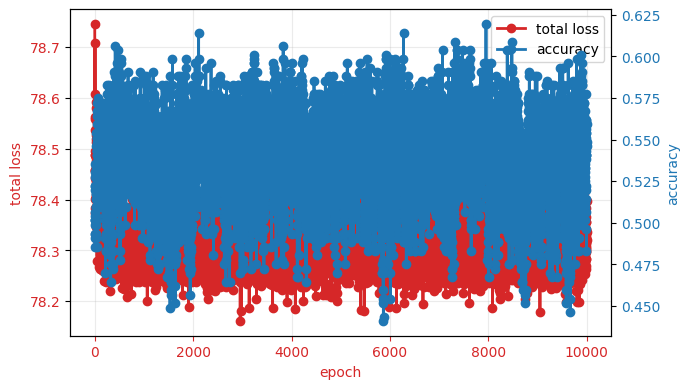

In [141]:
def plot(cum_loss_list, acc_epoch):
    """
    Plot total (cumulative) loss and validation accuracy per epoch
    on two y-axes, epochs on the x-axis starting at 0.
    """
    # handle unequal lengths safely
    n = min(len(cum_loss_list), len(acc_epoch))
    if n == 0:
        raise ValueError("Nothing to plot: empty lists.")
    loss = np.asarray(cum_loss_list[:n], dtype=float)
    acc  = np.asarray(acc_epoch[:n], dtype=float)
    epochs = np.arange(n)  # 0..n-1

    fig, ax1 = plt.subplots(figsize=(7, 4))

    # left y-axis: total loss (red)
    l1 = ax1.plot(epochs, loss, marker='o', linewidth=2, label='total loss', color='tab:red')
    ax1.set_xlabel('epoch', color='tab:red')
    ax1.set_ylabel('total loss', color='tab:red')
    ax1.tick_params(axis='x', colors='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True, which='both', axis='both', alpha=0.25)

    # right y-axis: accuracy (blue)
    ax2 = ax1.twinx()
    l2 = ax2.plot(epochs, acc, marker='o', linewidth=2, label='accuracy', color='tab:blue')
    ax2.set_ylabel('accuracy', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    # If your accuracy is in [0,1], uncomment to clamp nicely:
    # ax2.set_ylim(0.0, 1.0)

    # One legend for both lines
    lines = l1 + l2
    labels = [ln.get_label() for ln in lines]
    ax1.legend(lines, labels, loc='best')

    fig.tight_layout()
    plt.show()

plot(cum_loss_list, acc_epoch)

### Create submission.csv for kaggle

In [139]:
# Load the pre-trained model 
model.load_state_dict(torch.load('my_model.pth'))
model.eval()
all_ids, all_preds = [], []
with torch.no_grad():
    for ids, text, offsets, keywords in test_dataloader:
        logits = model(text,offsets,keywords)
        preds = logits.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_ids.extend(ids.cpu().tolist())

# ensure sorted by id like Kaggle expects
submission = pd.DataFrame({"id": all_ids, "target": all_preds}).sort_values("id")
submission.to_csv("submission.csv", index=False)
print(submission.head())
print("Saved submission.csv")

   id  target
0   0       0
1   2       0
2   3       0
3   9       1
4  11       1
Saved submission.csv
